In [1]:
%config StoreMagics.autorestore = True
%reset -f
# %store -z
%store -r
%whos

Variable                     Type              Data/Info
--------------------------------------------------------
PDMultiOrderROM_results      list              n=1050
PDMultiParamsMOR_results     list              n=2500
Tsam                         float             0.75
fullOrder                    int               80
hatMathcalPcl                LinearIOSystem    <LinearIOSystem>: sys[18]<...>0e+00  0.00000000e+00]]\n
hatMathcalPext               LinearIOSystem    <LinearIOSystem>: sys[32]<...> [0. 0.]\n     [0. 0.]]\n
hsvMathcalPext               ndarray           80: 80 elems, type `float64`, 640 bytes
mathcalC                     StateSpace        A = [[-100.]]\n\nB = [[1.<...>8.]]\n\nD = [[0.08008]]\n
mathcalEext                  LinearICSystem    <LinearICSystem>: sys[33]<...> [0. 0.]\n     [0. 0.]]\n
mathcalP                     LinearIOSystem    <LinearIOSystem>: sys[2]\<...>[[0. 0.]\n     [0. 0.]]\n
mathcalPcl                   LinearIOSystem    <LinearIOSystem>: sys[15]<.

In [2]:
import pickle
import numpy
import sympy
import scipy
import control
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import multiprocessing
from joblib import Parallel, delayed  
from tqdm.notebook import tqdm
import psutil

from custom_utils import ControlUtils
from custom_utils import ODEUtils

from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

numpy.set_printoptions(precision=3)
sympy.init_printing(use_latex='mathjax', use_unicode=True)
sympy.init_printing()
plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica", "axes.titley": 1.0 } )
%matplotlib inline

In [3]:
# Controller definition
Kp = 80e-6
Td = 10e0
N = 1.0e3
num =  [ Kp*((Td/N)+Td), Kp ]
den = [ (Td/N), 1 ]
mathcalC = control.tf2ss(num,den)

# s variable
s = control.TransferFunction.s

# Norm operator Delta
mathcalCPrime = control.ss(mathcalC.A,mathcalC.B,mathcalC.C,numpy.zeros(mathcalC.D.shape))
normInfmathcalC = ControlUtils.hinfnorm(mathcalC)[0]
normInfMathcalCPrime = ControlUtils.hinfnorm(mathcalCPrime)[0]
normInfsMathcalCPrime = ControlUtils.hinfnorm(s * control.ss2tf(mathcalCPrime))[0]
                        
# Controller matrices
Ac = mathcalC.A
Bv = mathcalC.B
Cw = mathcalC.C
Dw = mathcalC.D

# Closed-loop with FOM Extended Plant
Ap = mathcalPext.A
Bw = mathcalPext.B[:,0:1]
Bu = mathcalPext.B[:,1:2]
Cv = mathcalPext.C[0:1,:]
Cy = mathcalPext.C[-1:,:]
Dv = mathcalPext.D[0:1,:]
Dy = mathcalPext.D[-1:,:]
Acl = numpy.row_stack( [ numpy.column_stack( [ Ap + Bw@Dw@Cv, Bw@Cw ] ),
                                numpy.column_stack( [ Bv@Cv, Ac ] )
                                ] )
Bcl = numpy.row_stack( [ numpy.column_stack([Bw, Bu]),
                                numpy.column_stack( [ numpy.zeros( (Ac.shape[0],Bw.shape[1]) ), numpy.zeros( (Ac.shape[0],Bu.shape[1]) ) ] )
                                ] )
Ccl = numpy.row_stack( [ # numpy.column_stack( [ Cv, numpy.zeros( (Cv.shape[0],Ac.shape[0]) ) ] ),
                                numpy.column_stack( [ Cv@Ap + Cv@Bw@Dw@Cv, Cv@Bw@Cw ] ),
                                numpy.column_stack( [ Cy, numpy.zeros( (Cy.shape[0],Ac.shape[0]) ) ] )
                                ] )
Dcl = numpy.row_stack( [ # numpy.column_stack( [ numpy.zeros( (Cv.shape[0],Bw.shape[1]) ), numpy.zeros( (Cv.shape[0],Bu.shape[1]) ) ] ),
                                numpy.column_stack( [ Cv@Bw , Cv@Bu] ),
                                numpy.column_stack( [ numpy.zeros( (Cy.shape[0],Bw.shape[1]) ), numpy.zeros( (Cy.shape[0],Bu.shape[1]) ) ] )
                                ] )
mathcalPcl = control.ss(Acl,Bcl,Ccl,Dcl)
normInfMathcalPcl, normInfMathcalPcl_MIMO = ControlUtils.hinfnorm( mathcalPcl )

# Creating balanced form

# Getting Grammians (Factorized, check documentation for control.gram(.,'cf'/'of'))
WcL = numpy.array( control.gram(mathcalPext,'cf'), dtype=numpy.longdouble ).T
WoL = numpy.array( control.gram(mathcalPext,'of'), dtype=numpy.longdouble ).T

# Getting SVD
U, S2, V = numpy.linalg.svd(WcL.T @ (WoL @ WoL.T) @ WcL, compute_uv=True)
S = numpy.diag( S2**(1/2) )

# Getting transformation
T = ( (S**(1/2)) @ U.T ) @ numpy.linalg.inv(WcL)
invT = numpy.linalg.inv(T)

# Computing balanced Grammians
WcBal = T @ (WcL @ WcL.T) @ T.T
WoBal = invT.T @ (WoL @ WoL.T) @ invT

# Getting Hankel singular values
hsv = numpy.linalg.eigvals(WcBal@WoBal)**(1/2)
                              
def PDMultiOrderROM_func(Tsam, reduction_order):
        # Creating Projection Matrices
        proj = numpy.row_stack([numpy.eye(reduction_order,reduction_order), numpy.zeros((mathcalPext.A.shape[0]-reduction_order,reduction_order))])
        V_proj = invT @ proj
        WT_proj = proj.T @ T

        # Get ROM matrices
        hatA = WT_proj @ mathcalPext.A @ V_proj
        hatB = WT_proj @ mathcalPext.B
        hatC = mathcalPext.C @ V_proj
        
        # Closed-loop with ROM Extended Plant
        hatAp_ext = hatA
        hatBw_ext = hatB[:,0:1]
        hatBu_ext = hatB[:,1:2]
        hatCv_ext = hatC[0:1,:]
        hatCy_ext = hatC[-1:,:]
        hatDv_ext = hatMathcalPext.D[0:1,:]
        hatDy_ext = hatMathcalPext.D[-1:,:]
        hatAcl = numpy.row_stack( [ numpy.column_stack( [ hatAp_ext + hatBw_ext@Dw@hatCv_ext, hatBw_ext@Cw ] ),
                                    numpy.column_stack( [ Bv@hatCv_ext, Ac ] )
                                    ] )
        hatBcl = numpy.row_stack( [ numpy.column_stack([hatBw_ext, hatBu_ext]),
                                    numpy.column_stack( [ numpy.zeros( (Ac.shape[0],hatBw_ext.shape[1]) ), numpy.zeros( (Ac.shape[0],hatBu_ext.shape[1]) ) ] )
                                    ] )
        hatCcl = numpy.row_stack( [ # numpy.column_stack( [ hatCv_ext, numpy.zeros( (hatCv_ext.shape[0],Ac.shape[0]) ) ] ),
                                    numpy.column_stack( [ hatCv_ext@hatAp_ext + hatCv_ext@hatBw_ext@Dw@hatCv_ext, hatCv_ext@hatBw_ext@Cw ] ),
                                    numpy.column_stack( [ hatCy_ext, numpy.zeros( (hatCy_ext.shape[0],Ac.shape[0]) ) ] )
                                    ] )
        hatDcl = numpy.row_stack( [ # numpy.column_stack( [ numpy.zeros( (hatCv_ext.shape[0],hatBw_ext.shape[1]) ), numpy.zeros( (hatCv_ext.shape[0],hatBu_ext.shape[1]) ) ] ),
                                    numpy.column_stack( [ hatCv_ext@hatBw_ext , hatCv_ext@hatBu_ext] ),
                                    numpy.column_stack( [ numpy.zeros( (hatCy_ext.shape[0],hatBw_ext.shape[1]) ), numpy.zeros( (hatCy_ext.shape[0],hatBu_ext.shape[1]) ) ] )
                                    ] )
        hatMathcalPcl = control.ss(hatAcl,hatBcl,hatCcl,hatDcl)
        normInfHatMathcalPcl, normInfHatMathcalPcl_MIMO = ControlUtils.hinfnorm( hatMathcalPcl )
        
        #######################################################################
        
        # Computing norms for small-gain stability condition
        mathcalEcl = mathcalPcl - hatMathcalPcl
        normInfMathcalEcl, normInfMathcalEcl_MIMO = ControlUtils.hinfnorm( mathcalEcl )
        
        normInfDelta = 2*Tsam/numpy.pi
        kappa_dv = normInfDelta * normInfmathcalC \
                        + normInfDelta * normInfsMathcalCPrime * normInfDelta \
                        + normInfMathcalCPrime * normInfDelta
        
        return (mathcalPext, hatMathcalPext, reduction_order,
                mathcalC, Kp, Td, N, Tsam,
                mathcalPcl, normInfMathcalPcl, normInfMathcalPcl_MIMO,
                hatMathcalPcl, normInfHatMathcalPcl, normInfHatMathcalPcl_MIMO,
                mathcalEcl, normInfMathcalEcl, normInfMathcalEcl_MIMO,
                kappa_dv)

In [4]:
# Sampling time grid, numericas are too sensitive
# samplings_lims = [900.0e-3,920.0e-3]
samplings_lims = [790.0e-3,840.0e-3]
# samplings_steps = 5
samplings_steps = 50
samplings = numpy.linspace(samplings_lims[0],samplings_lims[1],samplings_steps)

reduction_order_lims = [5,25]
# reduction_order_steps = 5
reduction_order_steps = 50
reduction_order_steps = reduction_order_lims[1]-reduction_order_lims[0]+1
reduction_orders = numpy.linspace(reduction_order_lims[0],reduction_order_lims[1],reduction_order_steps)
# print(reduction_orders)

# Creation of arguements lists for the parallel execution of function smallgain_condition(*args)
jobs_args_list = []
for i in range(samplings_steps):
    for j in range(reduction_order_steps):
        jobs_args_list.append([ (i,j), (samplings[i], int(reduction_orders[j])) ])

Jobs execution

In [ ]:
# Execution of jobs using multiprocess managed by Parallel 
# (Very recommended since standard python multithread does not take advantage of all cores due to GIL)
# (The other option is to use CPython)
num_cores = multiprocessing.cpu_count()
PDMultiOrderROM_results = Parallel(n_jobs=num_cores)\
                        (\
                            delayed( lambda idx,args: (idx, PDMultiOrderROM_func(*args)) )\
                                ( jobs_args_list[k][0], jobs_args_list[k][1] )\
                                for k in tqdm(range(len(jobs_args_list)), position=0)\
                        )
                        
# Save the computation results to a pickle with timestamp
utcnow, micros = datetime.now().strftime('%Y_%m_%d-%H_%M_%S.%f').split('.')
pickle_filename = "PDMultiOrderROM_results_{0}_{1}.pickle".format( utcnow, micros[:-3] ) 
with open(pickle_filename, 'wb') as f:
    pickle.dump(PDMultiOrderROM_results, f)

Loading previous results

In [5]:
# Read the computation results from a pickle with timestamp
pickle_filename = "PDMultiOrderROM_results_2023_11_16-02_02_33_099.pickle"
with open(pickle_filename, 'rb') as f:
    PDMultiOrderROM_results = pickle.load(f)

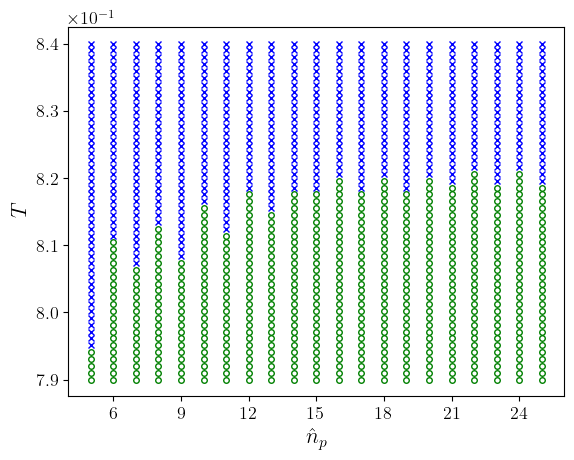

<Figure size 640x480 with 0 Axes>

In [6]:
for k in range(len(PDMultiOrderROM_results)):
    (i,j),(mathcalPext, hatMathcalPext, reduction_order,
                mathcalC, Kp, Td, N, Tsam,
                mathcalPcl, normInfMathcalPcl, normInfMathcalPcl_MIMO,
                hatMathcalPcl, normInfHatMathcalPcl, normInfHatMathcalPcl_MIMO,
                mathcalEcl, normInfMathcalEcl, normInfMathcalEcl_MIMO,
                kappa_dv) = PDMultiOrderROM_results[k]
    
    # A priori stability condition
    small_gain_cond_FOM = normInfMathcalPcl*kappa_dv
    small_gain_cond_ROM = (normInfMathcalPcl+normInfMathcalEcl)*kappa_dv
    
    # if(small_gain_cond_FOM>=1):
    #      plt.plot(reduc_order, Tsam, marker="x", markersize=4, markerfacecolor='r', markeredgecolor='r')
    if(small_gain_cond_ROM>=1):
        plt.plot(reduction_order, Tsam, marker="x", markersize=4, markerfacecolor='b', markeredgecolor='b')
    else:
        plt.plot(reduction_order, Tsam, marker="o", markersize=4, markerfacecolor='none', markeredgecolor='g')

plt.ticklabel_format(axis='y', scilimits=(-0,-0))
# plt.ticklabel_format(axis='x', scilimits=(0,1))
plt.tick_params(axis='y', labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().xaxis.get_offset_text().set_fontsize(13)
plt.gca().yaxis.get_offset_text().set_fontsize(13)
plt.ylabel('$T$', fontsize=16)
plt.xlabel('$\\hat{n}_p$', fontsize=16)
plt.show()
plt.savefig('reduction_vs_sampling.png', format='png')

In [7]:
%store -d PDMultiOrderROM_results
%store PDMultiOrderROM_results

Stored 'PDMultiOrderROM_results' (list)
